In [1]:
import numpy as np
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
%matplotlib inline


import os
import shutil
import glob
# import xrft

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.tri import Triangulation
from mpas_tools.viz import mesh_to_triangles
from mpas_tools.ocean import depth
from mpas_tools.viz import colormaps    

In [2]:
import numpy as np
from scipy.sparse import csr_matrix
def topo_filt(mesh, ring=1):
    """
    Build a topology-based filter for an MPAS mesh, assembling a
    sparse matrix representing a 'tophat' operator for each cell
    in the mesh.
    Attributes
    ----------
    mesh : xarray Dataset
        The MPAS-O mesh data structure.
    ring : integer
        The number of topological 'rings' in filters.
    """
    # Darren Engwirda
#-- form the 1-ring adj. graph for cells as a sparse matrix
    xvec = np.array([], dtype=np.int32)
    ivec = np.array([], dtype=np.int32)
    jvec = np.array([], dtype=np.int32)
    # nEdgesOnCell = np.asarray(mesh["nEdgesOnCell"][:])
    # cellsOnCell = np.asarray(mesh["cellsOnCell"][:])
    nEdgesOnCell = mesh['nEdgesOnCell'].values
    cellsOnCell = mesh['cellsOnCell'].values


    for edge in range(np.max(nEdgesOnCell)):
        have = nEdgesOnCell > edge
        cidx = np.argwhere(have).ravel()
        okay = cellsOnCell[have, edge] - 1 >= 0
        cidx = cidx[okay]
        cadj = cellsOnCell[cidx, edge] - 1
        ivec = np.hstack((ivec, cidx))
        jvec = np.hstack((jvec, cadj))
        xvec = np.hstack((
            xvec, np.ones(cadj.size, dtype=np.int32)))
    ivec = np.hstack((
        ivec, np.arange(0, cellsOnCell.shape[0])))
    jvec = np.hstack((
        jvec, np.arange(0, cellsOnCell.shape[0])))
    xvec = np.hstack((xvec, np.ones(
        cellsOnCell.shape[0], dtype=np.int32)))
#-- expand to adj.-of-adj. through matrix multiplication
    filt = csr_matrix((xvec, (ivec, jvec))) ** ring
#-- reset all nz values to one, for un-weighted averages
    filt.data[:] = 1
    return filt

In [3]:
ytdir = {}
mmdir = {}

grid = {}


ytdir['bgc0-bkmix1'] = '/global/cscratch1/sd/ytakano/chrys/GMPAS-JRA1p4_EC30to60E2r2_chrysalis-bgc0-bkmix1_5-10-5-tranco2/run/'
ytdir['bgc0-tranco2'] = '/global/cscratch1/sd/ytakano/chrys/GMPAS-JRA1p4_EC30to60E2r2_chrysalis-bgc0-tranco2/run/'
ytdir['bgc0-redi1200'] = '/global/cscratch1/sd/ytakano/chrys/GMPAS-JRA1p4_EC30to60E2r2_chrysalis-bgc0-redi1200-tranco2/run/'
# mmdir['30-60-tranco2'] = '/global/cscratch1/sd/maltrud/E3SM_simulations/queueForHPSS/GMPAS-JRA1p4_EC30to60E2r2_OECO_20tr_chrys01/ocn/hist/'
# mmdir['30-60-L80_tranco2'] = '/global/cscratch1/sd/maltrud/E3SM_simulations/queueForHPSS/GMPAS-JRA1p4_EC30to60E2r2L80_OECO_20tr_chrys01/ocn/hist/'
mmdir['30-10-tranco2'] = '/global/cscratch1/sd/maltrud/E3SM_simulations/onHPSS/GMPAS-JRA1p4_RRS30to10v3_OECO_20tr_chrys01/ocn/hist/'


fname_prefixes = ['GMPAS-JRA1p4_EC30to60E2r2_chrysalis-bgc0-bkmix1_5-10-5-tranco2',
                  'GMPAS-JRA1p4_EC30to60E2r2_chrysalis-bgc0-tranco2',
                  'GMPAS-JRA1p4_EC30to60E2r2_chrysalis-bgc0-redi1200-tranco2',
                  # 'GMPAS-JRA1p4_EC30to60E2r2_OECO_20tr_chrys01',
                  # 'GMPAS-JRA1p4_EC30to60E2r2L80_OECO_20tr_chrys01',
                  'GMPAS-JRA1p4_RRS30to10v3_OECO_20tr_chrys01',
                 ]

run_dirs = [ytdir['bgc0-bkmix1'],
            ytdir['bgc0-tranco2'],
            ytdir['bgc0-redi1200'],
            # mmdir['30-60-tranco2'],
            # mmdir['30-60-L80_tranco2'],
            mmdir['30-10-tranco2'],
           ]

fname_suffix = '.mpaso.hist.am.timeSeriesStatsMonthly.*'

labels = ['bgc0-bkmix1', 
          'bgc0',
          'bgc0-redi1200',
          # '30-60-tranco2',
          # '30-60-L80_tranco2',
          '30-10',
         ]

grid['30-10'] = xr.open_dataset('/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/oRRS30to10v3/oRRS30to10v3.171128.nc')
grid['bgc0'] = xr.open_dataset('/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc')
# grid['30-60-L80'] = xr.open_dataset('/global/cscratch1/sd/anirbans/GMPAS-JRA-RYF8485_EC30to60E2r2L80_chrys01.mpaso.rst.0003-01-01_00000.nc')
grid['bgc0-bkmix1'] = grid['bgc0']
grid['bgc0-redi1200'] = grid['bgc0']



flist = {}
for lab, fname, rd in zip(labels, fname_prefixes, run_dirs):
    flist[lab] = sorted(glob.glob(rd +  '/'+ fname+ fname_suffix))

In [4]:
for lab in labels:
    print(len(flist[lab]))

744
744
744
731


In [5]:
%%time

# Do the filtering for the 30-10 grid 
filt_3010 = {}
for i in range(1,11):
    filt_3010[i] = topo_filt(grid['30-10'], ring=i)
    print(i)

1
2
3
4
5
6
7
8
9
10
CPU times: user 12min 13s, sys: 40.4 s, total: 12min 53s
Wall time: 12min 54s


In [6]:
ds={}
for lab in labels:
    ds[lab] = xr.open_dataset(flist[lab][602])

In [7]:
def qty_gt_lt_L(arr_in, filtN, grid):
    """
    Takes a cell-centered variable (scalar) and 
    filter of some topological size, returns the 
    corresponding filtered scalar, the subfilter qty
    and the lengthscale L
    """
    arr = np.reshape(arr_in, (arr_in.size, 1))
    areaCell = grid.areaCell.values
    area = np.reshape(areaCell, (areaCell.size, 1))
    
    L = (np.sqrt(filtN * area)[:,0])/1e3
    qbar_L = ((filtN * arr) / (filtN * np.ones((filtN.shape[0], 1))))[:,0]
    qprime_L = arr_in - qbar_L
    
    return qbar_L, qprime_L, L

In [10]:
def qty_filtered(arr_in, filtN):
    """
    Takes a cell-centered variable (scalar) and 
    filter of some topological size, returns the 
    corresponding filtered scalar
    """
    arr = np.reshape(arr_in, (arr_in.size, 1))
    qbar_L = ((filtN * arr) / (filtN * np.ones((filtN.shape[0], 1))))[:,0]

    return qbar_L

In [8]:
%%time

vels = ['timeMonthly_avg_velocityZonal', 'timeMonthly_avg_velocityMeridional']
qtys = ['u','v']
vec = {}
Lscale = {}
Lscale[0] = (np.sqrt(grid['30-10'].areaCell.values))/1e3

for k1, k2 in zip(qtys, vels):
    vec[k1] = ds['30-10'][k2].isel(Time=0, nVertLevels=0).values
    for k in filt_3010.keys():
        vec[k1+'bar_'+str(k)], vec[k1+'prime_'+str(k)], Lscale[k] = qty_gt_lt_L(vec[k1], filt_3010[k], grid['30-10'])

CPU times: user 1min 40s, sys: 54.7 s, total: 2min 35s
Wall time: 2min 36s


In [9]:
ke = 0.5*(vec['u']**2 + vec['v']**2)

In [12]:
%%time

kebar = {}
keprime = {}
kefiltered = {}
kesmall = {}


for i in filt_3010.keys():
    kebar[i] = 0.5*(vec['ubar_'+str(i)]**2 + vec['vbar_'+str(i)]**2)
    keprime[i] = 0.5*(vec['uprime_'+str(i)]**2 + vec['vprime_'+str(i)]**2)
    kefiltered[i] = qty_filtered(ke, filt_3010[i])
    kesmall[i] = kefiltered[i] - kebar[i]

CPU times: user 32.6 s, sys: 17.8 s, total: 50.5 s
Wall time: 50.4 s


In [21]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

blue = cm.get_cmap('Blues', 256)
green = cm.get_cmap('Greens', 256)
red = cm.get_cmap('Reds', 256)
grey = cm.get_cmap('Greys', 256)
bone = cm.get_cmap('bone_r', 256)
binary = cm.get_cmap('binary', 256)
hot = cm.get_cmap('hot_r', 256)
gray = cm.get_cmap('gray_r', 256)


newcolors5 = blue(np.linspace(0, 1, 256))**2*grey(np.linspace(0, 1, 256))**0.2
newcmp5 = ListedColormap(newcolors5[::-1], name='BlueGrey')

newcolors7 = blue(np.linspace(0, 1, 256))**1.5*green(np.linspace(0, 1, 256))**0.3*grey(np.linspace(0, 1, 256))**0.03
newcmp7 = ListedColormap(newcolors7[::-1], name='BluegreenGrey')

newcmp6 = ListedColormap(newcolors5, name='BlueGrey_r')
newcmp8 = ListedColormap(newcolors7, name='BlueGreenGrey_r')

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
color7 = '#b38f00'
color8 = '#00e6e6'
color9 = '#666699'

In [14]:
lat = grid['30-10'].latCell.values
lon = grid['30-10'].lonCell.values
latdeg = np.degrees(lat)
londeg = np.degrees(lon)

In [29]:
%%time

kebardiff = {}
Ldiff = {}
Linter = {}

for i in range(2,11):
    Linter[i] = 0.5*(Lscale[i-1] + Lscale[i])
    kebardiff[i] = (kebar[i] - kebar[i-1])
    Ldiff[i] = (Lscale[i] - Lscale[i-1])


    

CPU times: user 176 ms, sys: 289 ms, total: 465 ms
Wall time: 462 ms


In [17]:
def get_indices(grid, latbnds = (10, 30), lonbnds = (310, 330)):
    lat = grid.latCell.values
    lon = grid.lonCell.values    
    indsOut = np.where((lon>np.deg2rad(lonbnds[0]))&(lon<np.deg2rad(lonbnds[-1]))&(lat>np.deg2rad(latbnds[0]))&(lat<np.deg2rad(latbnds[-1])))[0]
    return indsOut



In [19]:
from matplotlib.patches import Rectangle

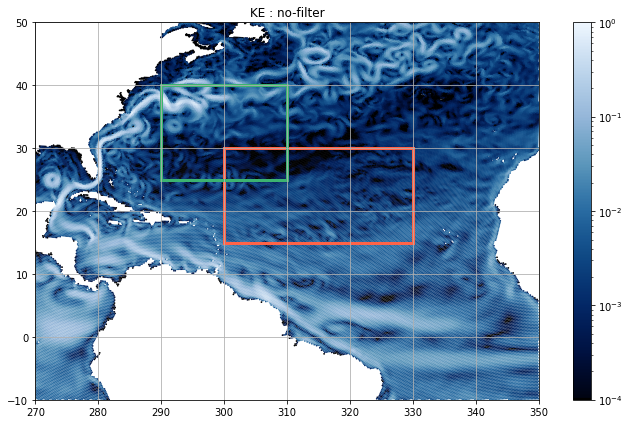

In [172]:
plt.figure(figsize=(10,6), tight_layout=True)

indsNA = get_indices(grid['30-10'], latbnds=(-10,50), lonbnds = (270,350))
plt.scatter(londeg[indsNA], latdeg[indsNA], c=ke[indsNA], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'KE : no-filter');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))

plt.grid()

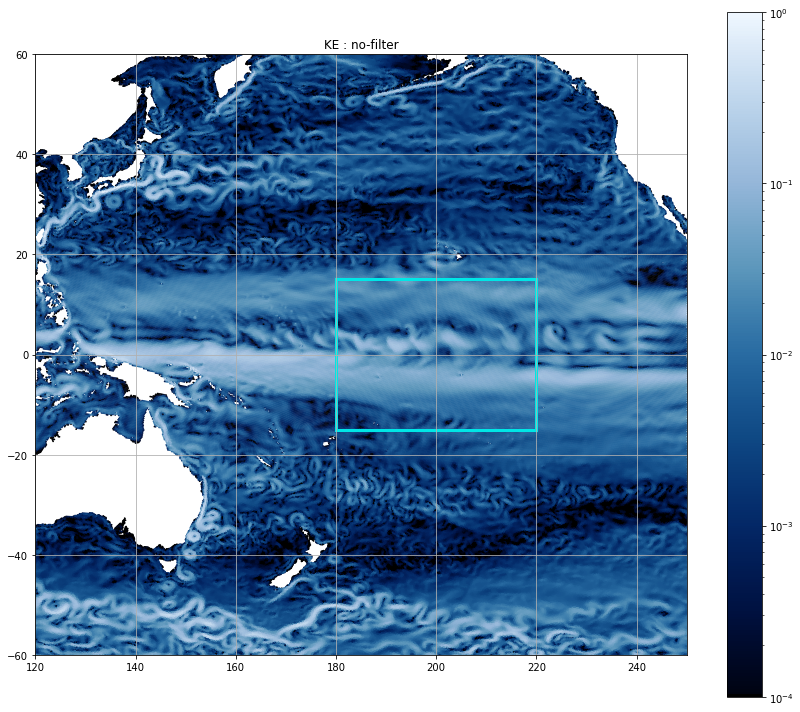

In [185]:
plt.figure(figsize=(12,10), tight_layout=True)

indsPO = get_indices(grid['30-10'], latbnds=(-60,60), lonbnds = (120,250))
plt.scatter(londeg[indsPO], latdeg[indsPO], c=ke[indsPO], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);
plt.title(r'KE : no-filter');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))
# ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))

plt.grid()

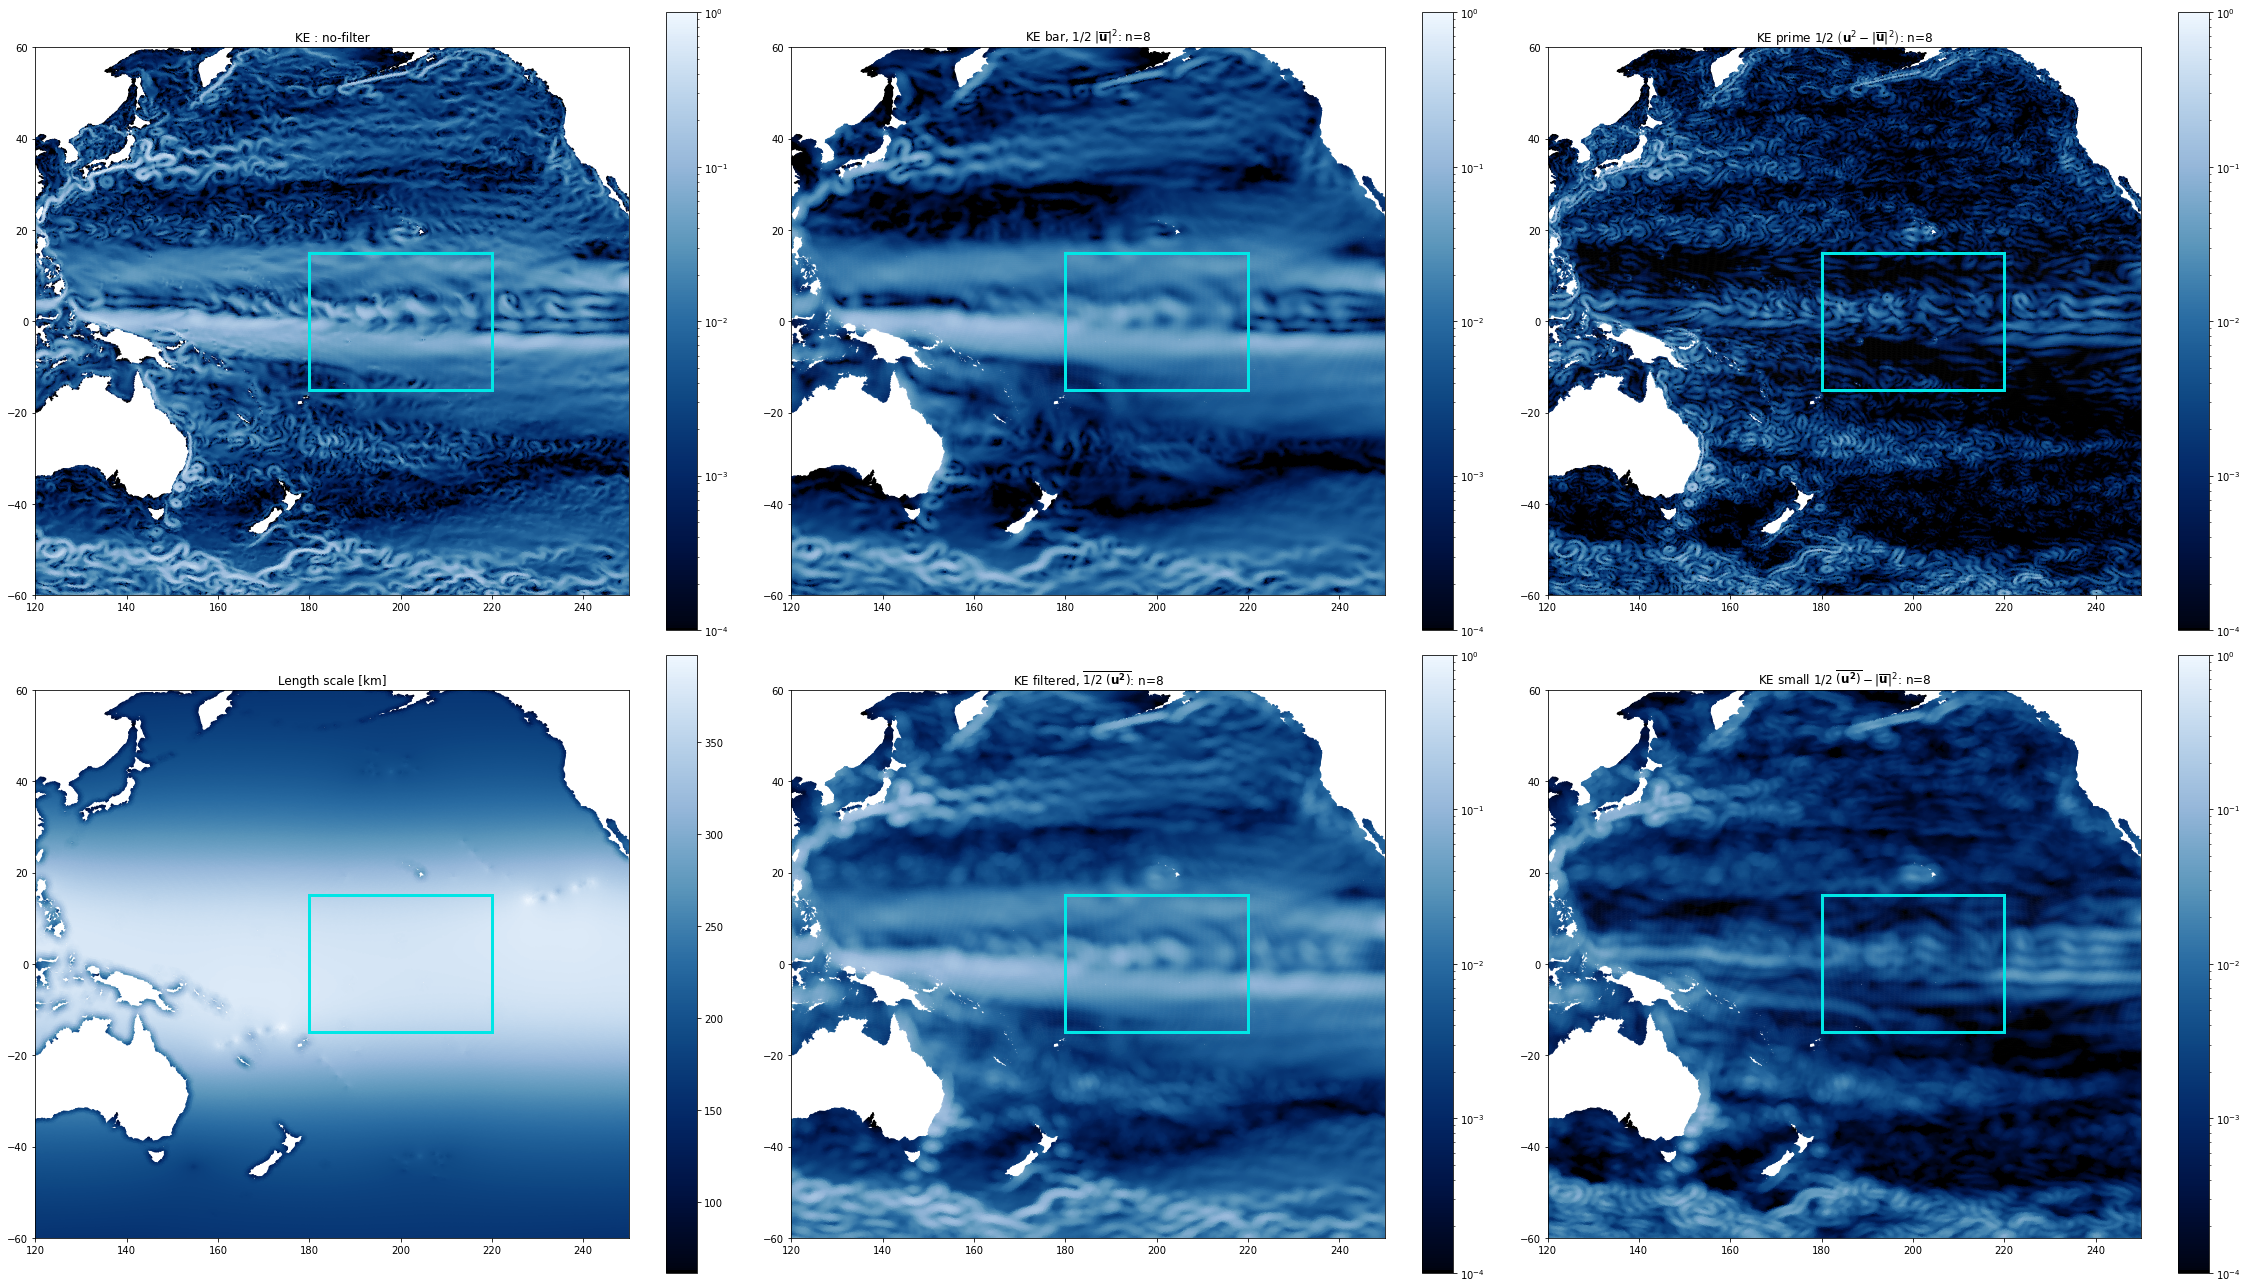

In [186]:
plt.figure(figsize=(32,18), tight_layout=True)

plt.subplot(231)
plt.scatter(londeg[indsPO], latdeg[indsPO], c=ke[indsPO], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);

plt.title(r'KE : no-filter');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))
# plt.grid()


plt.subplot(234)
plt.scatter(londeg[indsPO], latdeg[indsPO], c=Lscale[8][indsPO], s=0.5, cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);

plt.title(r'Length scale [km]');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))


plt.subplot(232)
plt.scatter(londeg[indsPO], latdeg[indsPO], c=kebar[8][indsPO], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);

plt.title(r'KE bar, $1/2~{|\overline{\mathbf{u}}|}^2$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))


plt.subplot(233)
plt.scatter(londeg[indsPO], latdeg[indsPO], c=keprime[8][indsPO], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);

plt.title(r'KE prime $1/2~\left( {\mathbf{u}}^2 - {|\overline{\mathbf{u}}|}^2\right)$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))


plt.subplot(235)
plt.scatter(londeg[indsPO], latdeg[indsPO], c=kefiltered[8][indsPO], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);

plt.title(r'KE filtered, $\overline{1/2~\left(\mathbf{u^2}\right)}$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))


plt.subplot(236)
plt.scatter(londeg[indsPO], latdeg[indsPO], c=kesmall[8][indsPO], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-60,60]);plt.xlim([120,250]);

plt.title(r'KE small $1/2~\overline{\left(\mathbf{u^2}\right)} - {|\overline{\mathbf{u}}|}^2$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((180,-15), 40, 30, lw=3, ec= color8, fc='none'))


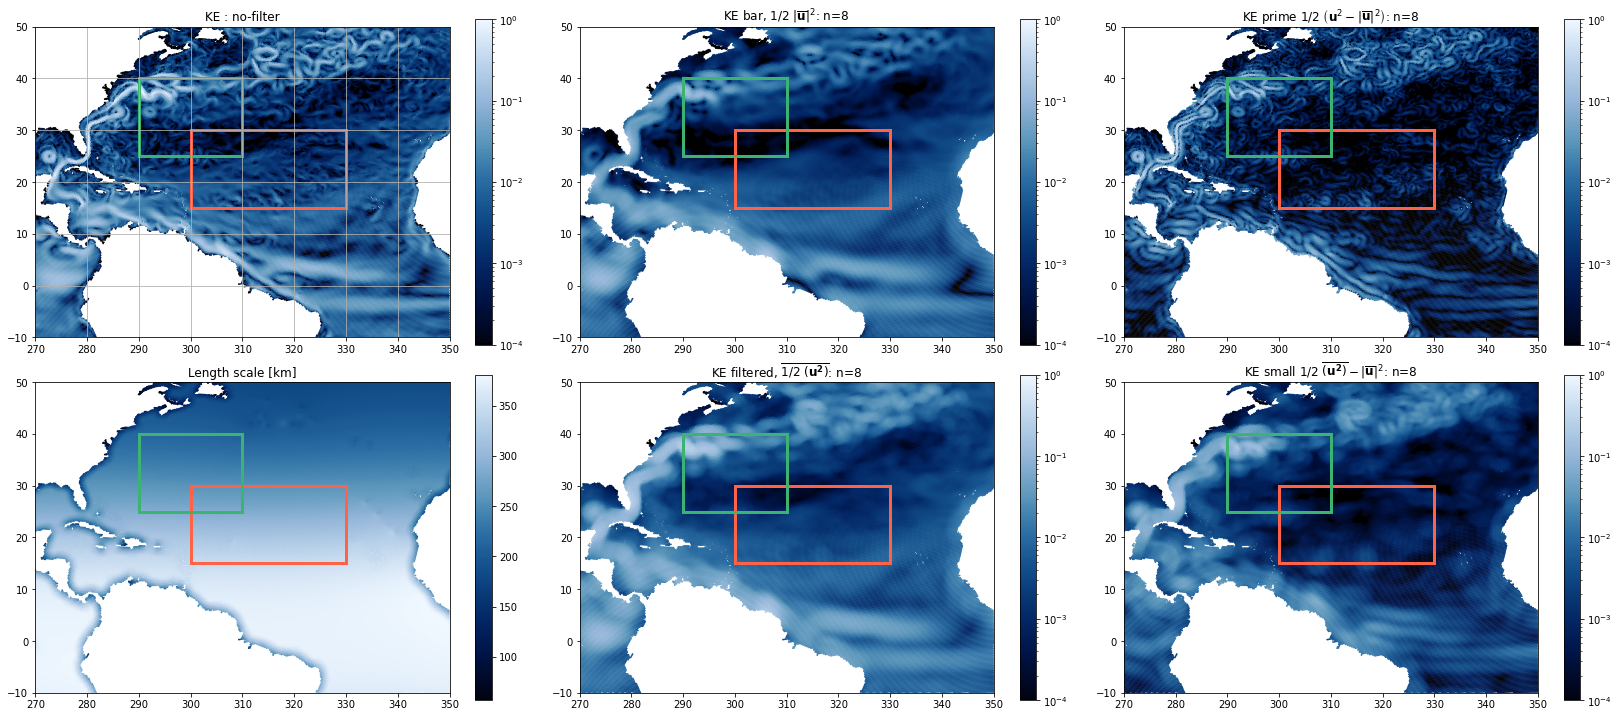

In [176]:
plt.figure(figsize=(23,10), tight_layout=True)

indsNA = get_indices(grid['30-10'], latbnds=(-10,50), lonbnds = (270,350))


plt.subplot(231)
plt.scatter(londeg[indsNA], latdeg[indsNA], c=ke[indsNA], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'KE : no-filter');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))
plt.grid()


plt.subplot(234)
plt.scatter(londeg[indsNA], latdeg[indsNA], c=Lscale[8][indsNA], s=0.5, cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'Length scale [km]');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))


plt.subplot(232)
plt.scatter(londeg[indsNA], latdeg[indsNA], c=kebar[8][indsNA], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'KE bar, $1/2~{|\overline{\mathbf{u}}|}^2$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))


plt.subplot(233)
plt.scatter(londeg[indsNA], latdeg[indsNA], c=keprime[8][indsNA], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'KE prime $1/2~\left( {\mathbf{u}}^2 - {|\overline{\mathbf{u}}|}^2\right)$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))



plt.subplot(235)
plt.scatter(londeg[indsNA], latdeg[indsNA], c=kefiltered[8][indsNA], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'KE filtered, $\overline{1/2~\left(\mathbf{u^2}\right)}$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))



plt.subplot(236)
plt.scatter(londeg[indsNA], latdeg[indsNA], c=kesmall[8][indsNA], s=0.5,norm=LogNorm(vmin=1e-4, vmax=1e0), cmap=newcmp5);plt.colorbar();
plt.ylim([-10,50]);plt.xlim([270,350]);
plt.title(r'KE small $1/2~\overline{\left(\mathbf{u^2}\right)} - {|\overline{\mathbf{u}}|}^2$: n=8');
ax = plt.gca()
ax.set_aspect('equal')
ax.add_patch(Rectangle((300,15), 30, 15, lw=3, ec= color1, fc='none'))
ax.add_patch(Rectangle((290,25), 20, 15, lw=3, ec= color3, fc='none'))





In [187]:
indsNA = get_indices(grid['30-10'], latbnds=(-10,50), lonbnds = (270,350))
indsPO = get_indices(grid['30-10'], latbnds=(-60,60), lonbnds = (120,250))


indsNA1 = get_indices(grid['30-10'], latbnds=(15,30), lonbnds = (300,330))
indsNA2 = get_indices(grid['30-10'], latbnds=(25,40), lonbnds = (290,310))
indsPO1 = get_indices(grid['30-10'], latbnds=(-15,15), lonbnds = (180,220))




In [64]:
Ek = {}
kappa = {}
for r in kebardiff.keys():
    Ek[r] = -Linter[r]**2 * kebardiff[r] / Ldiff[r]
    kappa[r] = Linter[r]**(-1)

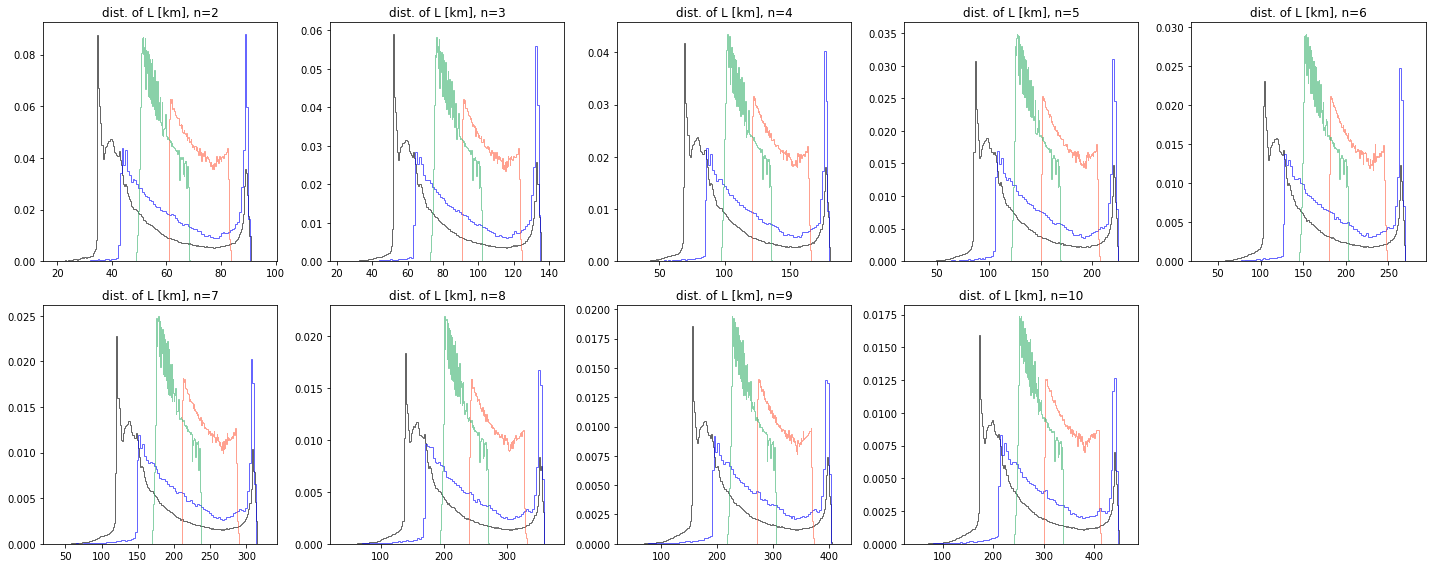

In [189]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(Linter[r], bins=200, histtype='step', density='True', color='k', alpha=0.6);
    plt.hist(Linter[r][indsNA], bins=100, histtype='step', density='True', color='b', alpha=0.6);

#     plt.hist(Linter[r][indsPO], bins=100, histtype='step', density='True', color=color5, alpha=0.6);

#     plt.hist(Linter[r][indsPO1], bins=100, histtype='step', density='True', color=color8, alpha=0.6);


    plt.hist(Linter[r][indsNA1], bins=100, histtype='step', density='True', color=color1, alpha=0.6);
    plt.hist(Linter[r][indsNA2], bins=100, histtype='step', density='True', color=color3, alpha=0.6);
    plt.title('dist. of L [km], n=%s' %r)

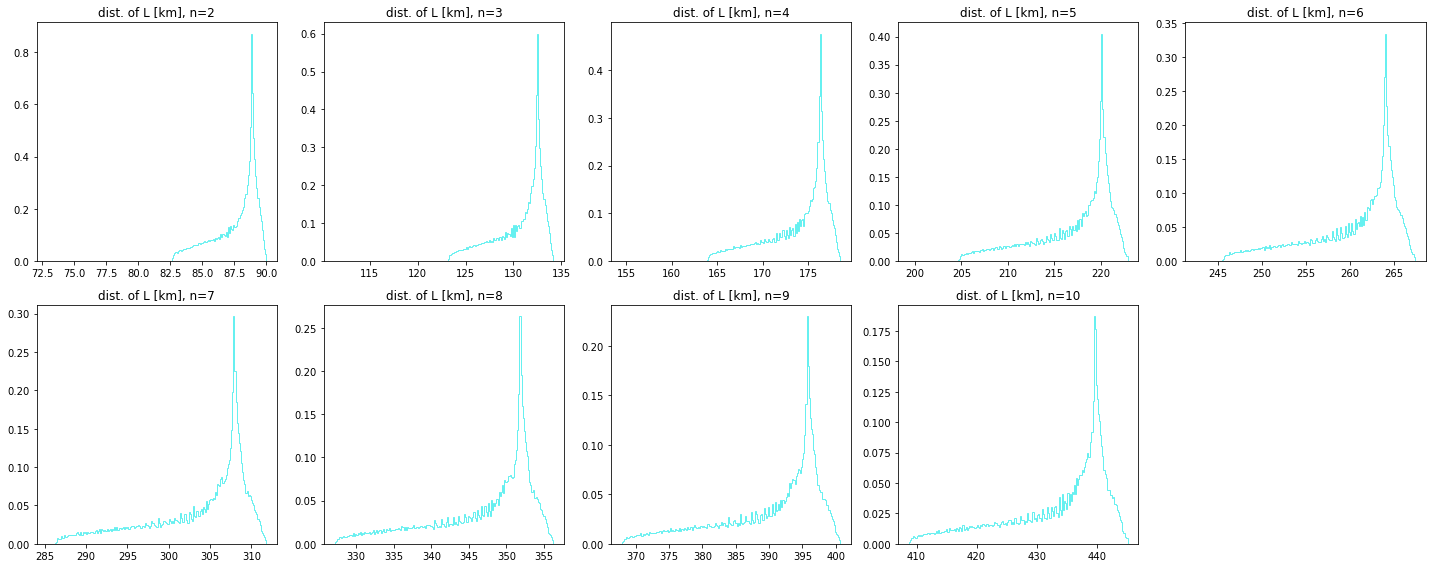

In [193]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)
    # plt.hist(Linter[r], bins=200, histtype='step', density='True', color='k', alpha=0.6);

    # plt.hist(Linter[r][indsPO], bins=400, histtype='step', density='True', color=color5, alpha=0.6);

    plt.hist(Linter[r][indsPO1], bins=200, histtype='step', density='True', color=color8, alpha=0.6);
    plt.title('dist. of L [km], n=%s' %r)

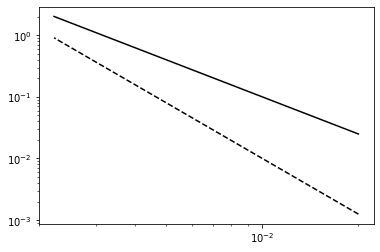

In [77]:
kr = (np.linspace(50,450, 450))**(-1)
Ek2 = 1e-5*kr ** (-2)
Ek3 = 1e-8*kr ** (-3)
plt.plot(kr, Ek2, color='k')
plt.plot(kr, Ek3, linestyle='dashed', color='k')

plt.xscale('log')
plt.yscale('log')

In [95]:
print(Linter[8][indsNA1].min(), Linter[8][indsNA1].max(), len(Linter[8][indsNA1]))

240.7702641206659 331.39167906559686 12356


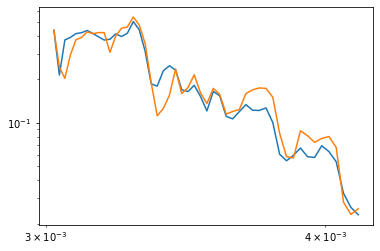

In [131]:
Lb = np.linspace(Linter[8][indsNA1].min(), Linter[8][indsNA1].max())
Ll = Lb[:-1]
Lu = Lb[1:]
Lm = 0.5*(Ll+Lu)
Ekm = np.zeros_like(Lm)

Ekm2 = np.zeros_like(Lm)

for i in range(len(Lm)):
    Ekm[i] = np.mean(np.abs(Ek[8][indsNA1][(Linter[8][indsNA1]>=Ll[i])&(Linter[8][indsNA1]<Lu[i])]))

    Ekm2[i] = np.mean(Ek[8][indsNA1][(Linter[8][indsNA1]>=Ll[i])&(Linter[8][indsNA1]<Lu[i])&(Ek[8][indsNA1]>0)])

plt.plot(Lm**-1, Ekm);plt.xscale('log');plt.yscale('log')
plt.plot(Lm**-1, Ekm2);plt.xscale('log');plt.yscale('log')

In [201]:
def get_meanEk_from_points(L, Ek):
    Lbnds = np.linspace(L.min(), L.max())
    Ll = Lbnds[:-1]
    Lu = Lbnds[1:]
    Lm = 0.5*(Ll+Lu)
    Ekm = np.zeros_like(Lm)
    for i in range(len(Lm)):
        Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])
    return Lm**-1, Ekm


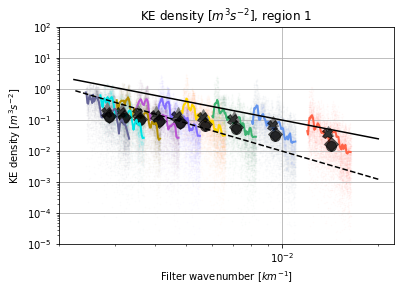

In [133]:
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(kappa[r][indsNA1], Ek[r][indsNA1], c=colors[i], s=1, alpha=0.01);
    km, Ekm = get_meanEk_from_points(Linter[r][indsNA1], Ek[r][indsNA1])
    plt.plot(km, Ekm, color=colors[i], alpha=1, linewidth=2)
    plt.plot(km.mean(), Ekm.mean(), marker='^', markersize=10, color='gray')
    plt.plot(np.median(km), np.median(Ekm), marker='X', markersize=10, color='k', alpha=0.6)
    plt.plot(np.median(kappa[r][indsNA1]), np.median(np.abs(Ek[r][indsNA1])), marker='o', markersize=10, color='k', alpha=0.6)

    plt.plot(np.median(kappa[r][indsNA1]), np.median(Ek[r][indsNA1][Ek[r][indsNA1]>0]), marker='D', markersize=10, color='k', alpha=0.6)




plt.plot(kr, Ek2, color='k');
plt.plot(kr, Ek3, linestyle='dashed', color='k');
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-5,1e2]);
plt.title(r'KE density [$m^3s^{-2}$], region 1')
plt.xlabel(r'Filter wavenumber [$km^{-1}$]')
plt.ylabel(r'KE density [$m^3s^{-2}$]')
plt.grid()

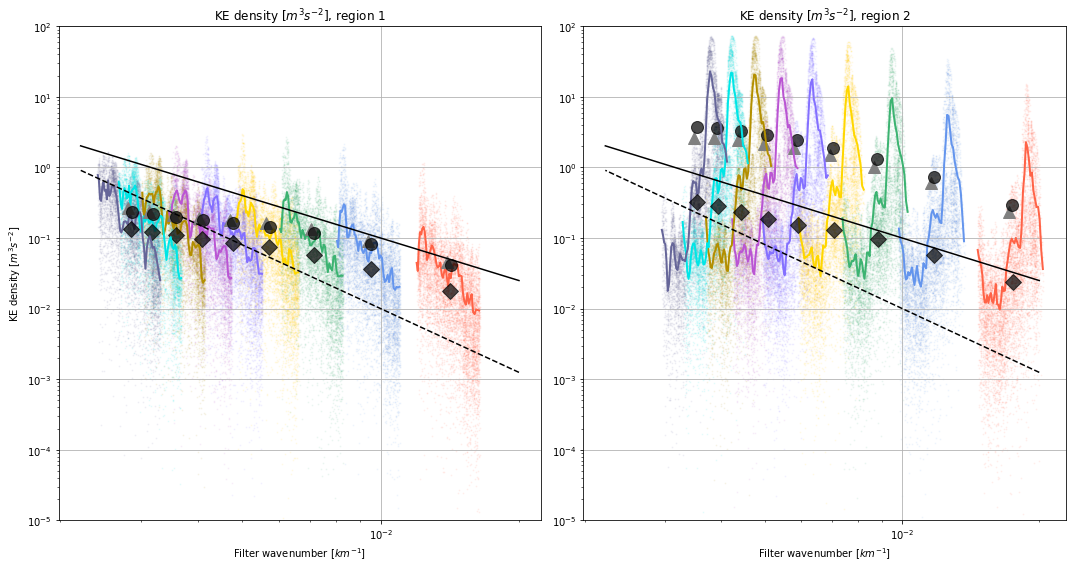

In [204]:
colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9]
kr = (np.linspace(50,450, 450))**(-1)
Ek2 = 1e-5*kr ** (-2)
Ek3 = 1e-8*kr ** (-3)


plt.figure(figsize=(15,8), tight_layout=True)
plt.subplot(121)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(kappa[r][indsNA1], Ek[r][indsNA1], c=colors[i], s=1, alpha=0.06);
    km, Ekm = get_meanEk_from_points(Linter[r][indsNA1], Ek[r][indsNA1])
    plt.plot(km, Ekm, color=colors[i], alpha=1, linewidth=2)
    plt.plot(km.mean(), Ekm.mean(), marker='^', markersize=12, color='gray')
    plt.plot(np.median(kappa[r][indsNA1]), np.median(Ek[r][indsNA1][Ek[r][indsNA1]>0]), marker='D', markersize=12, color='k', alpha=0.7)

    plt.plot(np.mean(kappa[r][indsNA1]), np.mean(Ek[r][indsNA1][Ek[r][indsNA1]>0]), marker='o', markersize=12, color='k', alpha=0.7)


plt.plot(kr, Ek2, color='k');
plt.plot(kr, Ek3, linestyle='dashed', color='k');
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-5,1e2]);
plt.title(r'KE density [$m^3s^{-2}$], region 1')
plt.xlabel(r'Filter wavenumber [$km^{-1}$]')
plt.ylabel(r'KE density [$m^3s^{-2}$]')
plt.grid()

plt.subplot(122)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(kappa[r][indsNA2], Ek[r][indsNA2], c=colors[i], s=1, alpha=0.06);
    km, Ekm = get_meanEk_from_points(Linter[r][indsNA2], Ek[r][indsNA2])
    plt.plot(km, Ekm, color=colors[i], alpha=1, linewidth=2)
    plt.plot(np.mean(km), np.mean(Ekm), marker='^', markersize=12, color='gray')
    plt.plot(np.median(kappa[r][indsNA2]), np.median(Ek[r][indsNA2][Ek[r][indsNA2]>0]), marker='D', markersize=12, color='k', alpha=0.7)
    plt.plot(np.mean(kappa[r][indsNA2]), np.mean(Ek[r][indsNA2][Ek[r][indsNA2]>0]), marker='o', markersize=12, color='k', alpha=0.7)


plt.plot(kr, Ek2, color='k');
plt.plot(kr, Ek3, linestyle='dashed', color='k');
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-5,1e2]);
plt.xlabel(r'Filter wavenumber [$km^{-1}$]')
plt.title(r'KE density [$m^3s^{-2}$], region 2')
plt.grid()

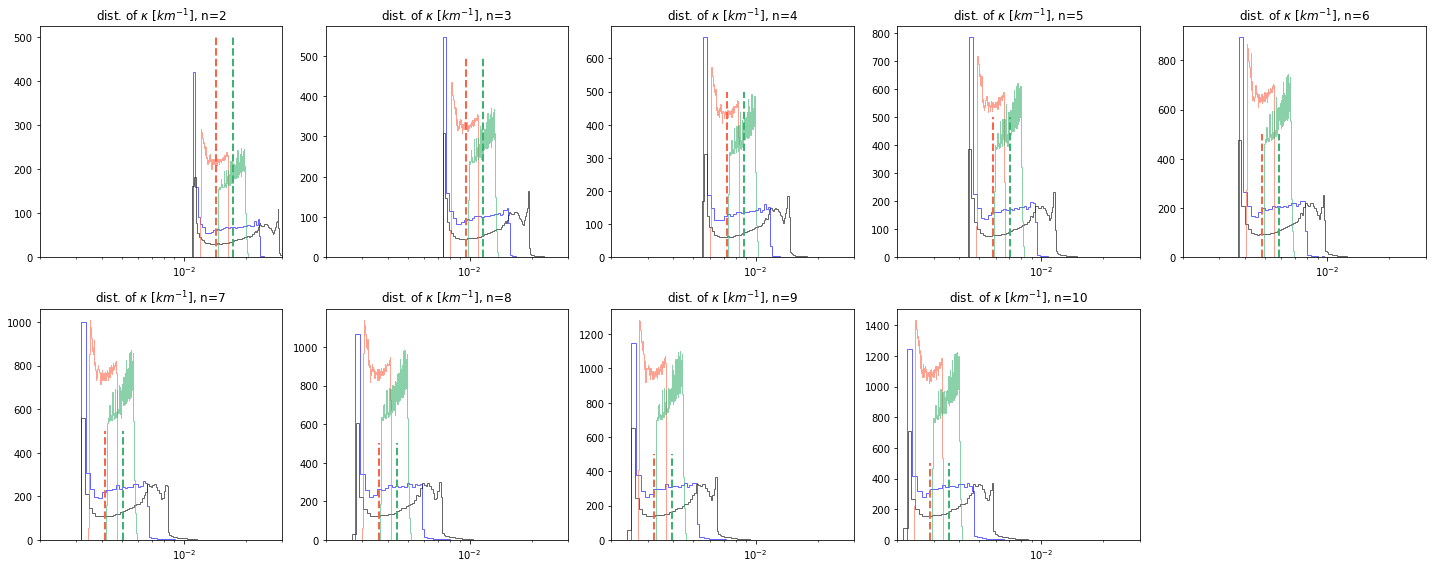

In [164]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(kappa[r], bins=200, histtype='step', density='True', color='k', alpha=0.6);
    plt.hist(kappa[r][indsNA], bins=100, histtype='step', density='True', color='b', alpha=0.6);
    plt.hist(kappa[r][indsNA1], bins=100, histtype='step', density='True', color=color1, alpha=0.6);
    plt.hist(kappa[r][indsNA2], bins=100, histtype='step', density='True', color=color3, alpha=0.6);
    plt.vlines(np.median(kappa[r][indsNA1][Ek[r][indsNA1]>0]), 0,500,color=color1, linewidth=2, linestyle='dashed')
    plt.vlines(np.median(kappa[r][indsNA2][Ek[r][indsNA2]>0]), 0,500,color=color3, linewidth=2, linestyle='dashed')
    
    plt.xscale('log')
    plt.xlim([2e-3,3e-2])
    plt.title(r'dist. of $\kappa$ [$km^{-1}$], n=%s' %r)

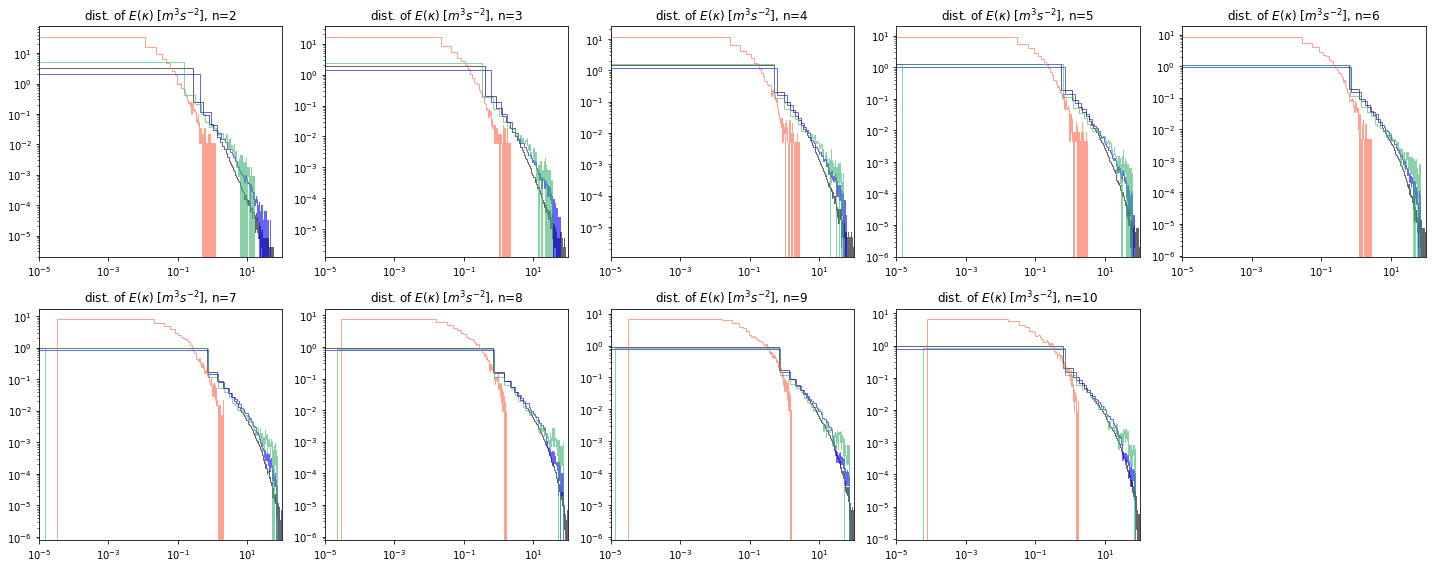

In [155]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(Ek[r][Ek[r]>0], bins=200, histtype='step', density=True, log=True,color='k', alpha=0.6);
    plt.hist(Ek[r][indsNA][Ek[r][indsNA]>0], bins=100, histtype='step', density=True, log=True,color='b', alpha=0.6);
    plt.hist(Ek[r][indsNA1][Ek[r][indsNA1]>0], bins=100, histtype='step', density=True, log=True,color=color1, alpha=0.6);
    plt.hist(Ek[r][indsNA2][Ek[r][indsNA2]>0], bins=100, histtype='step', density=True, log=True,color=color3, alpha=0.6);
    plt.xscale('log')
    plt.xlim([1e-5,1e2])
    plt.title(r'dist. of $E(\kappa)$ [$m^3s^{-2}$], n=%s' %r)

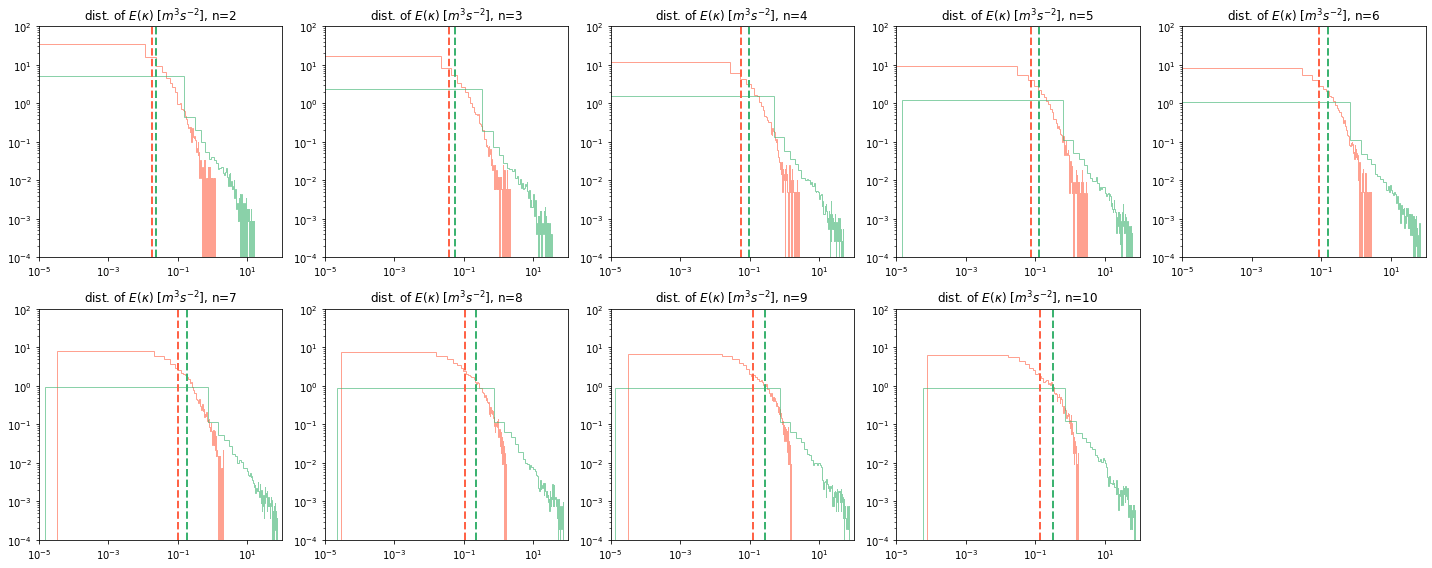

In [165]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)
    # plt.hist(Ek[r][Ek[r]>0], bins=200, histtype='step', density=True, log=True,color='k', alpha=0.6);
    # plt.hist(Ek[r][indsNA][Ek[r][indsNA]>0], bins=100, histtype='step', density=True, log=True,color='b', alpha=0.6);
    plt.hist(Ek[r][indsNA1][Ek[r][indsNA1]>0], bins=100, histtype='step', density=True, log=True,color=color1, alpha=0.6);
    plt.hist(Ek[r][indsNA2][Ek[r][indsNA2]>0], bins=100, histtype='step', density=True, log=True,color=color3, alpha=0.6);
    plt.vlines(np.median(Ek[r][indsNA1][Ek[r][indsNA1]>0]), 1e-4,1e2,color=color1, linewidth=2, linestyle='dashed')
    plt.vlines(np.median(Ek[r][indsNA2][Ek[r][indsNA2]>0]), 1e-4,1e2,color=color3, linewidth=2, linestyle='dashed')
    plt.xscale('log')
    plt.xlim([1e-5,1e2])

    plt.ylim([1e-4,1e2])
    plt.title(r'dist. of $E(\kappa)$ [$m^3s^{-2}$], n=%s' %r)

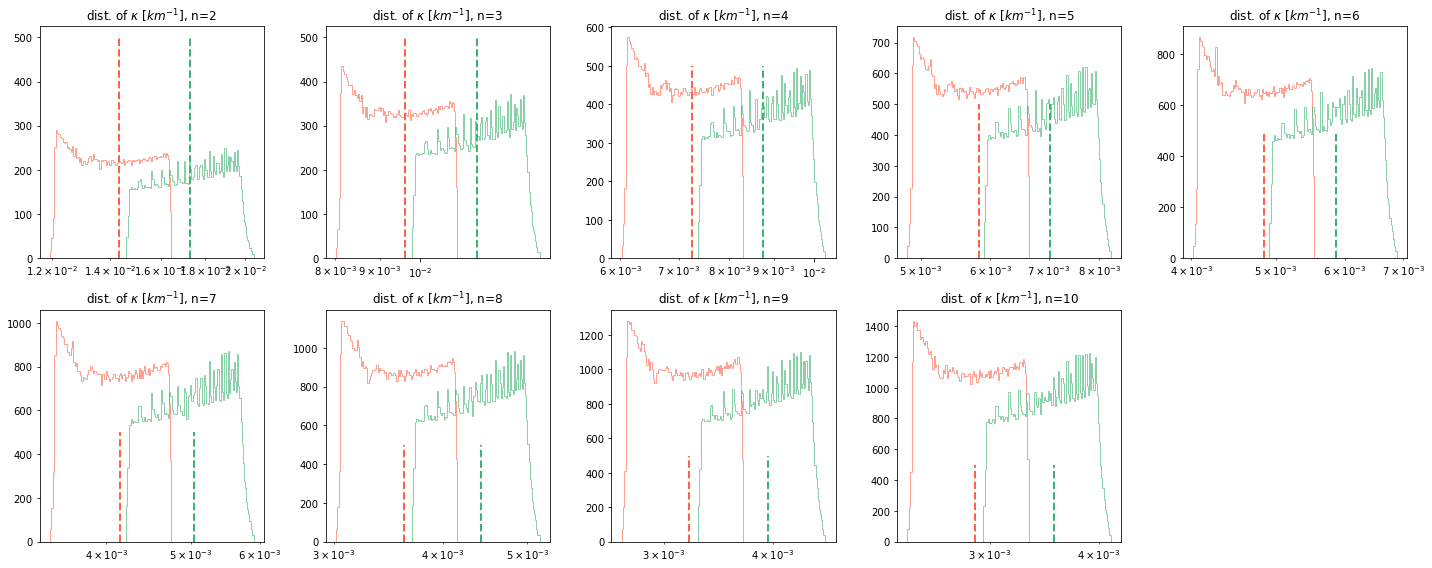

In [170]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)

    plt.hist(kappa[r][indsNA1], bins=100, histtype='step', density='True', color=color1, alpha=0.6);
    plt.hist(kappa[r][indsNA2], bins=100, histtype='step', density='True', color=color3, alpha=0.6);
    plt.vlines(np.median(kappa[r][indsNA1][Ek[r][indsNA1]>0]), 0,500,color=color1, linewidth=2, linestyle='dashed')
    plt.vlines(np.median(kappa[r][indsNA2][Ek[r][indsNA2]>0]), 0,500,color=color3, linewidth=2, linestyle='dashed')
    
    plt.xscale('log')
    # plt.xlim([2e-3,3e-2])
    plt.title(r'dist. of $\kappa$ [$km^{-1}$], n=%s' %r)

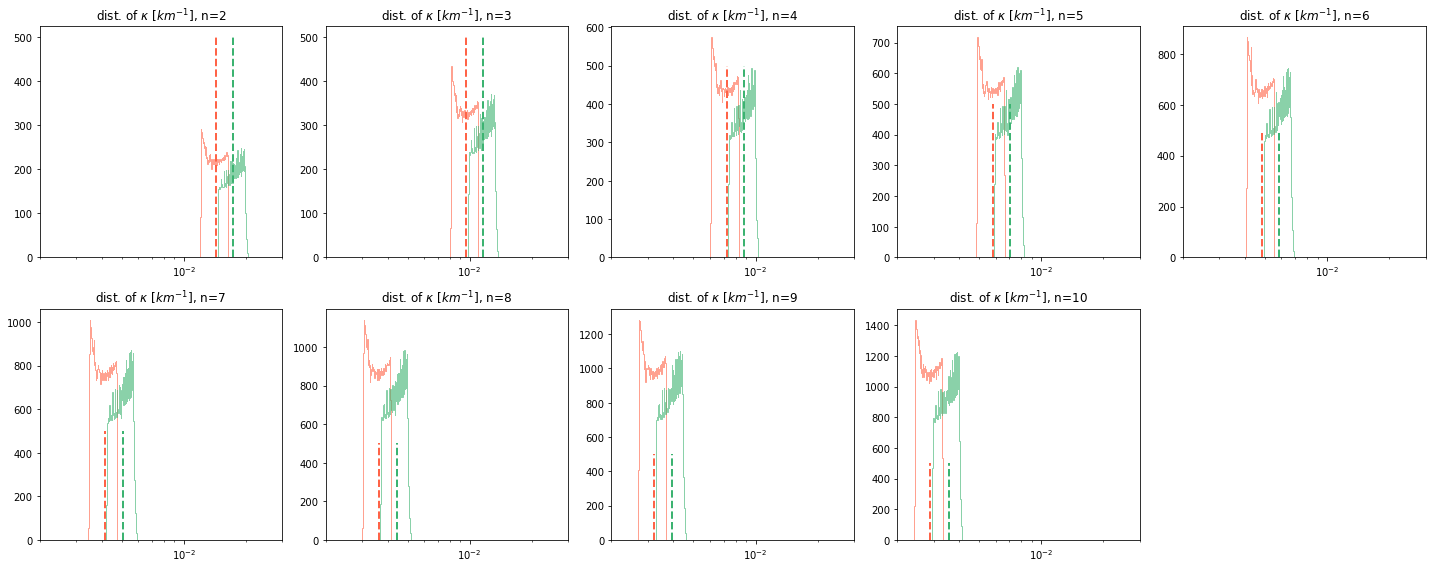

In [169]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)

    plt.hist(kappa[r][indsNA1], bins=100, histtype='step', density='True', color=color1, alpha=0.6);
    plt.hist(kappa[r][indsNA2], bins=100, histtype='step', density='True', color=color3, alpha=0.6);
    plt.vlines(np.median(kappa[r][indsNA1][Ek[r][indsNA1]>0]), 0,500,color=color1, linewidth=2, linestyle='dashed')
    plt.vlines(np.median(kappa[r][indsNA2][Ek[r][indsNA2]>0]), 0,500,color=color3, linewidth=2, linestyle='dashed')
    
    plt.xscale('log')
    plt.xlim([2e-3,3e-2])
    plt.title(r'dist. of $\kappa$ [$km^{-1}$], n=%s' %r)

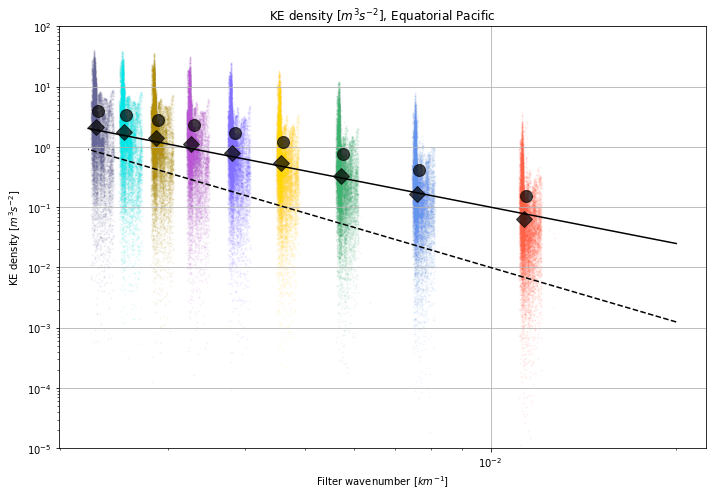

In [227]:
colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9]
kr = (np.linspace(50,450, 450))**(-1)
Ek2 = 1e-5*kr ** (-2)
Ek3 = 1e-8*kr ** (-3)


plt.figure(figsize=(10,7), tight_layout=True)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(kappa[r][indsPO1], Ek[r][indsPO1], c=colors[i], s=1, alpha=0.06);
    # km, Ekm = get_meanEk_from_points(Linter[r][indsPO1], Ek[r][indsPO1])
    # plt.plot(km, Ekm, color=colors[i], alpha=1, linewidth=2)
    # plt.plot(np.nanmean(km), np.nanmean(Ekm), marker='^', markersize=12, color='gray')
    plt.plot(np.median(kappa[r][indsPO1]), np.median(Ek[r][indsPO1][Ek[r][indsPO1]>0]), marker='D', markersize=12, color='k', alpha=0.7)
    plt.plot(np.mean(kappa[r][indsPO1]), np.mean(Ek[r][indsPO1][Ek[r][indsPO1]>0]), marker='o', markersize=12, color='k', alpha=0.7)


plt.plot(kr, Ek2, color='k');
plt.plot(kr, Ek3, linestyle='dashed', color='k');
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-5,1e2]);
plt.title(r'KE density [$m^3s^{-2}$], Equatorial Pacific')
plt.xlabel(r'Filter wavenumber [$km^{-1}$]')
plt.ylabel(r'KE density [$m^3s^{-2}$]')
plt.grid()



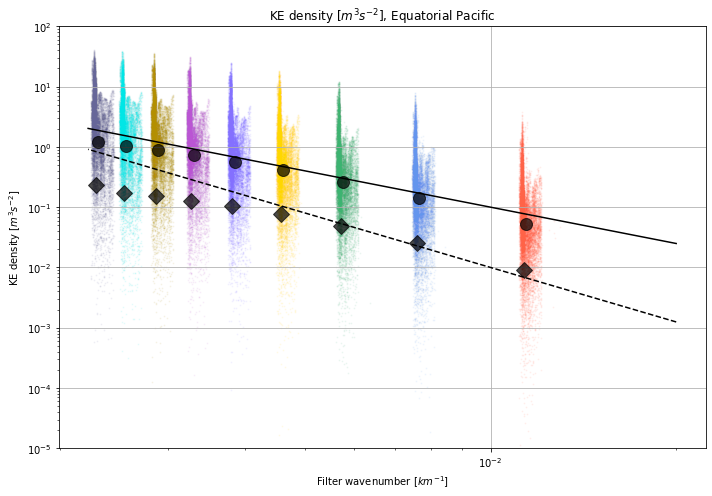

In [228]:
colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9]
kr = (np.linspace(50,450, 450))**(-1)
Ek2 = 1e-5*kr ** (-2)
Ek3 = 1e-8*kr ** (-3)


plt.figure(figsize=(10,7), tight_layout=True)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(kappa[r][indsPO1], Ek[r][indsPO1], c=colors[i], s=1, alpha=0.06);
    # km, Ekm = get_meanEk_from_points(Linter[r][indsPO1], Ek[r][indsPO1])
    # plt.plot(km, Ekm, color=colors[i], alpha=1, linewidth=2)
    # plt.plot(np.nanmean(km), np.nanmean(Ekm), marker='^', markersize=12, color='gray')
    plt.plot(np.median(kappa[r][indsPO1]), np.median(Ek[r][indsPO1]), marker='D', markersize=12, color='k', alpha=0.7)
    plt.plot(np.mean(kappa[r][indsPO1]), np.mean(Ek[r][indsPO1]), marker='o', markersize=12, color='k', alpha=0.7)


plt.plot(kr, Ek2, color='k');
plt.plot(kr, Ek3, linestyle='dashed', color='k');
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-5,1e2]);
plt.title(r'KE density [$m^3s^{-2}$], Equatorial Pacific')
plt.xlabel(r'Filter wavenumber [$km^{-1}$]')
plt.ylabel(r'KE density [$m^3s^{-2}$]')
plt.grid()




/tmp/ipykernel_29813/671447635.py:8: RuntimeWarning: Mean of empty slice
  Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])
/tmp/ipykernel_29813/671447635.py:8: RuntimeWarning: Mean of empty slice
  Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])
/tmp/ipykernel_29813/671447635.py:8: RuntimeWarning: Mean of empty slice
  Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])
/tmp/ipykernel_29813/671447635.py:8: RuntimeWarning: Mean of empty slice
  Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])
/tmp/ipykernel_29813/671447635.py:8: RuntimeWarning: Mean of empty slice
  Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])
/tmp/ipykernel_29813/671447635.py:8: RuntimeWarning: Mean of empty slice
  Ekm[i] = np.nanmean(Ek[(L>=Ll[i])&(L<Lu[i])&(Ek>0)])


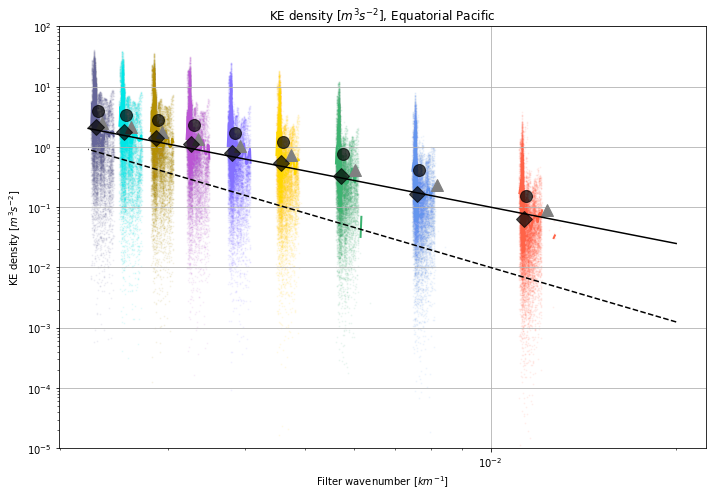

In [205]:
colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9]
kr = (np.linspace(50,450, 450))**(-1)
Ek2 = 1e-5*kr ** (-2)
Ek3 = 1e-8*kr ** (-3)


plt.figure(figsize=(10,7), tight_layout=True)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(kappa[r][indsPO1], Ek[r][indsPO1], c=colors[i], s=1, alpha=0.06);
    km, Ekm = get_meanEk_from_points(Linter[r][indsPO1], Ek[r][indsPO1])
    plt.plot(km, Ekm, color=colors[i], alpha=1, linewidth=2)
    plt.plot(np.nanmean(km), np.nanmean(Ekm), marker='^', markersize=12, color='gray')
    plt.plot(np.median(kappa[r][indsPO1]), np.median(Ek[r][indsPO1][Ek[r][indsPO1]>0]), marker='D', markersize=12, color='k', alpha=0.7)
    plt.plot(np.nanmean(kappa[r][indsPO1]), np.nanmean(Ek[r][indsPO1][Ek[r][indsPO1]>0]), marker='o', markersize=12, color='k', alpha=0.7)


plt.plot(kr, Ek2, color='k');
plt.plot(kr, Ek3, linestyle='dashed', color='k');
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-5,1e2]);
plt.title(r'KE density [$m^3s^{-2}$], Equatorial Pacific')
plt.xlabel(r'Filter wavenumber [$km^{-1}$]')
plt.ylabel(r'KE density [$m^3s^{-2}$]')
plt.grid()


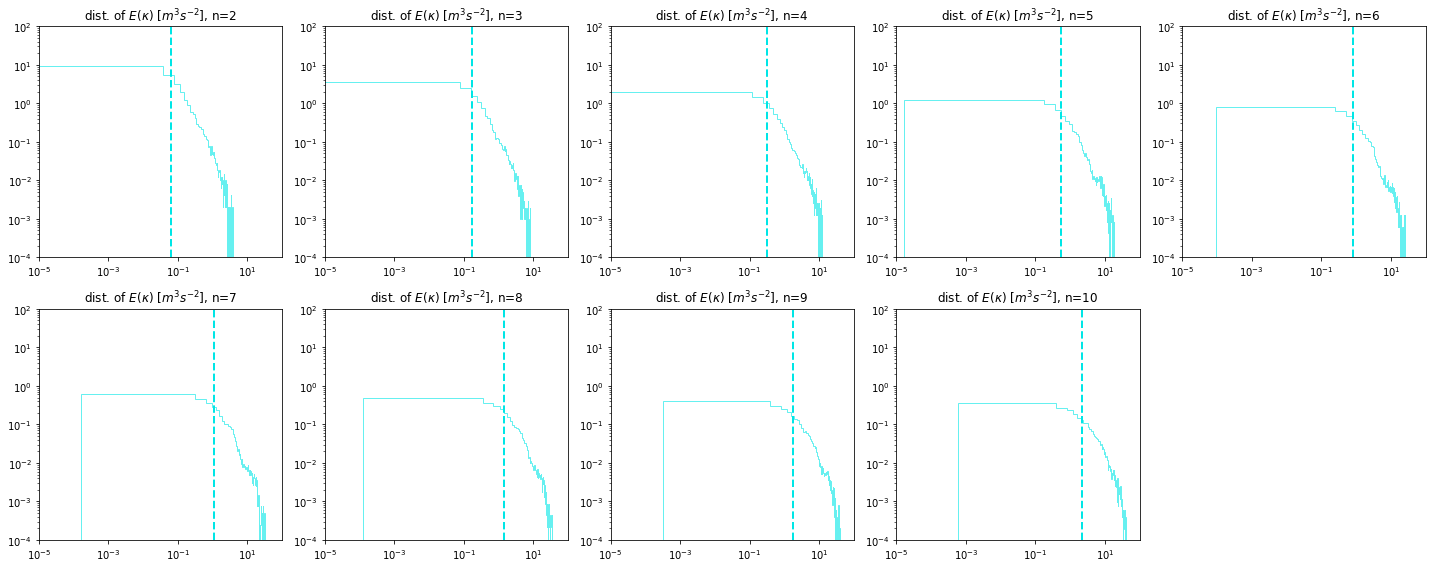

In [207]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(Ek[r][indsPO1][Ek[r][indsPO1]>0], bins=100, histtype='step', density=True, log=True,color=color8, alpha=0.6);
    plt.vlines(np.median(Ek[r][indsPO1][Ek[r][indsPO1]>0]), 1e-4,1e2,color=color8, linewidth=2, linestyle='dashed')
    plt.xscale('log')
    plt.xlim([1e-5,1e2])

    plt.ylim([1e-4,1e2])
    plt.title(r'dist. of $E(\kappa)$ [$m^3s^{-2}$], n=%s' %r)

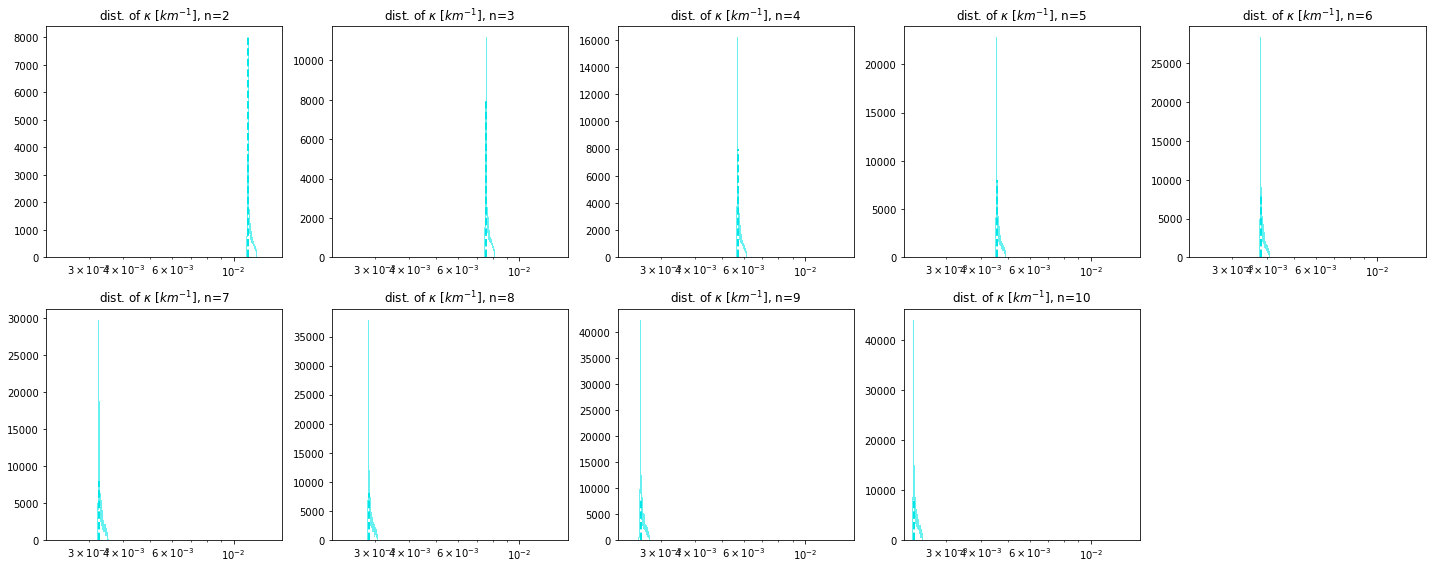

In [213]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)

    plt.hist(kappa[r][indsPO1], bins=500, histtype='step', density='True', color=color8, alpha=0.6);
    plt.vlines(np.median(kappa[r][indsPO1][Ek[r][indsPO1]>0]), 0,8000,color=color8, linewidth=2, linestyle='dashed')
    
    plt.xscale('log')
    plt.xlim([2.1e-3,1.5e-2])
    plt.title(r'dist. of $\kappa$ [$km^{-1}$], n=%s' %r)

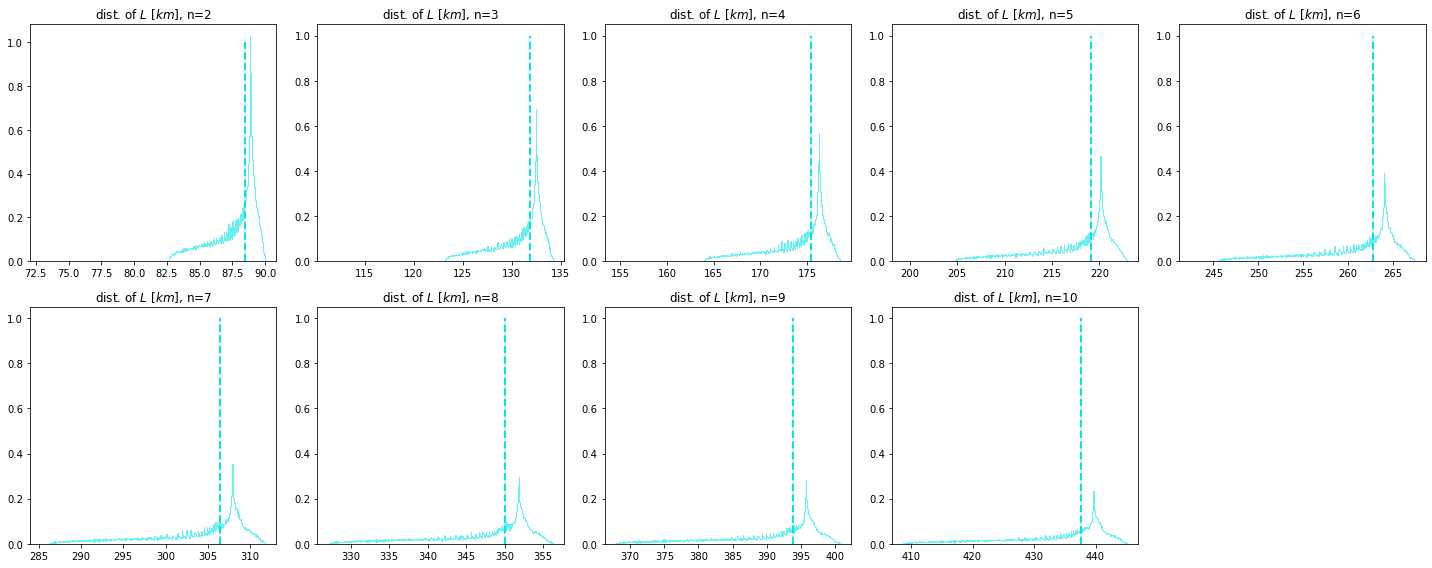

In [220]:
plt.figure(figsize=(20,8), tight_layout=True)
for i, r in enumerate(Ldiff.keys()):
    plt.subplot(2,5,i+1)

    plt.hist(Linter[r][indsPO1], bins=500, histtype='step', density='True', color=color8, alpha=0.6);
    plt.vlines(np.median(Linter[r][indsPO1][Ek[r][indsPO1]>0]), 0,1,color=color8, linewidth=2, linestyle='dashed')
    
    # plt.xscale('log')
    # plt.xlim([2.1e-3,1.5e-2])
    plt.title(r'dist. of $L$ [$km$], n=%s' %r)

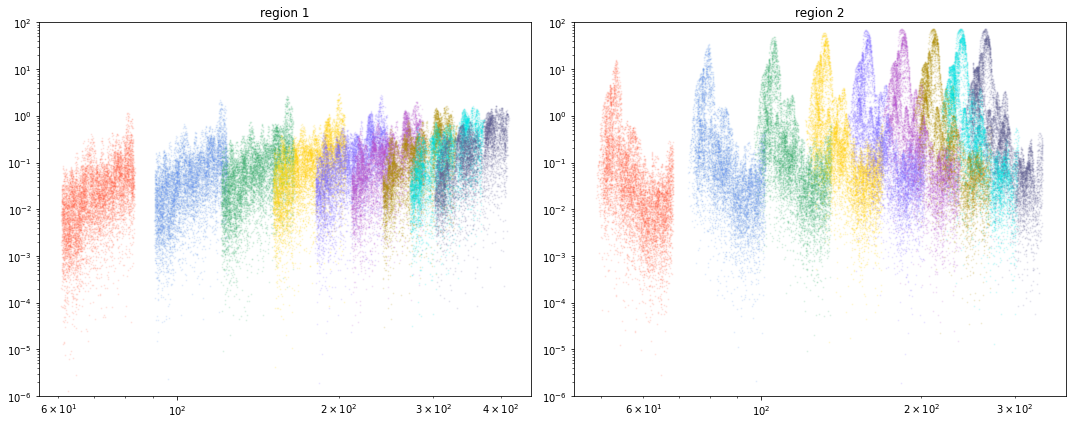

In [63]:
colors = [color1, color2, color3, color4, color5, color6, color7, color8, color9]
plt.figure(figsize=(15,6), tight_layout=True)
plt.subplot(121)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(Linter[r][indsNA1], Ek[r][indsNA1], c=colors[i], s=1, alpha=0.1);
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-6,1e2]);
plt.title('region 1');

plt.subplot(122)
for i, r in enumerate(kebardiff.keys()):
    plt.scatter(Linter[r][indsNA2], Ek[r][indsNA2], c=colors[i], s=1, alpha=0.1);
plt.xscale('log');plt.yscale('log');
plt.ylim([1e-6,1e2]);
plt.title('region 2');